---



---


# Stefano Talamona 822452 - Assignment 4 Advanced Machine Learning


---


---

## Task

The task I chose for this assignment is the image classification on a dataset containing images belonging to the corresponding weather condition shown in the picture itself. We could refer to this task as to ***image-based weather recognition***.

## Dataset

The dataset, which can be found [here](https://www.kaggle.com/pratik2901/multiclass-weather-dataset), is composed of a bit more than 1000 RGB images of vaious size divided into four classes: 
1.   Cloudy
2.   Rain
3.   Shine
4.   Sunrise

Note that the original dataset does not include any ground truth, so I wrote a .txt file containing the image labels. This file can be found in the folder I submitted (labels.txt).

Through the following cells I am going to provide additional information about this dataset.



In [1]:
# Mount Drive to load data from it
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
root_dir = '/content/drive/MyDrive'
base_dir = root_dir + '/data/Multi-class Weather Dataset'

Mounted at /content/drive


The images are divided in folders, each containing the samples belonging to one of the four classes. The data is loaded sequentially class-by-class so that I can exploit this spatial information to handle the preprocessing and the ground truth construction and loading.

In [2]:
# Load data
import numpy as np
import os
from tensorflow.keras.preprocessing import image

def load_images_from_folder(folder, idx_list):
  n_idx = 0
  images = []
  for filename in os.listdir(folder):
      if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
          # The images are resized while they are being loaded
          img = image.load_img(os.path.join(folder, filename), target_size = (224, 224))
          img = image.img_to_array(img).astype(int)
          if img is not None:
            images.append(img)
            n_idx += 1
  idx_list.append(n_idx)
  return images

idx_list = []
classes = ('Cloudy', 'Rain', 'Shine', 'Sunrise')
n_classes = len(classes)

folders = [os.path.join(base_dir, x) for x in classes]
all_images = [img for folder in folders for img in load_images_from_folder(folder, idx_list)]

print("Images loaded.")

Images loaded.


In [3]:
print("These are the folders from which the image data is loaded:"); folders

These are the folders from which the image data is loaded:


['/content/drive/MyDrive/data/Multi-class Weather Dataset/Cloudy',
 '/content/drive/MyDrive/data/Multi-class Weather Dataset/Rain',
 '/content/drive/MyDrive/data/Multi-class Weather Dataset/Shine',
 '/content/drive/MyDrive/data/Multi-class Weather Dataset/Sunrise']

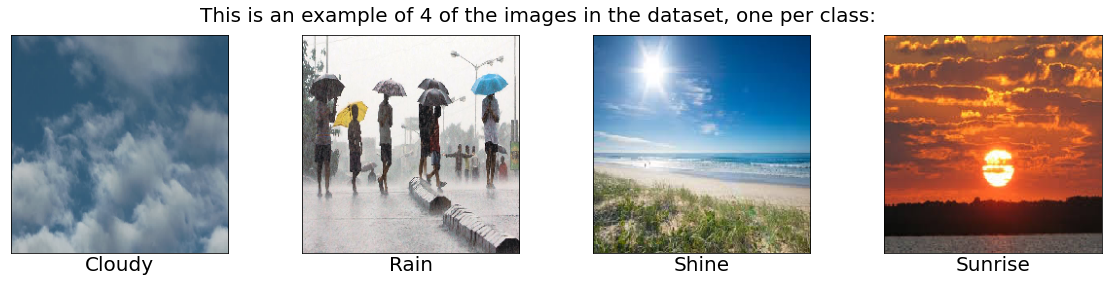

In [4]:
# Show a few samples of images in the dataset
from matplotlib import pyplot as plt

n = 4
index = 0
plt.figure(figsize = (20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(all_images[index + 8])
    index += idx_list[i]
    plt.gray()
    plt.suptitle(t = "This is an example of 4 of the images in the dataset, one per class:", fontsize = 20)
    plt.title(label = classes[i], fontsize = 20, y = -0.11)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Total number of images: 1125
Dimension of each image: (224, 224, 3)

Class name: 	 Number of samples:
Cloudy 			 300
Rain 			 215
Shine 			 253
Sunrise 		 357




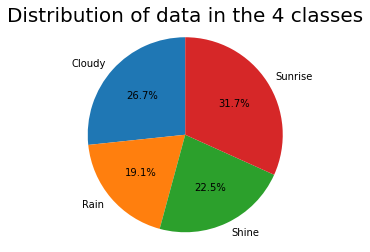

In [5]:
# Dimension and distribution of the samples in the dataset
data_dim = len(all_images)
print("Total number of images:", data_dim)
print("Dimension of each image:", np.shape(all_images[0]))
print("\nClass name: \t Number of samples:")
for i in range(n_classes):
  if len(classes[i]) > 6 : # Just to make the output more visually pleasing
    print(classes[i], "\t\t", idx_list[i])
  else:
    print(classes[i], "\t\t\t", idx_list[i])

print("\n")
ax = plt.subplot()
ax.pie(idx_list, labels = classes, autopct = '%1.1f%%', shadow = False, startangle = 90)
ax.axis('equal')
plt.title(label = "Distribution of data in the 4 classes", fontsize = 20)
plt.show()

The distribution of data looks balanced enough between the four classes.

## Preprocessing

A more specific preprocessing on the images will be performed later, after the chosen model will be introduced, for now the images have already been loaded with the desired size and format (*224x224x3 in RGB colorspace*) and the only preprocessing steps left to do are to convert datatypes and load and store the labels that compose the ground truth. The last preprocessing step in this "*Preprocessing*" section will be to divide the data into *trainset* and *testset* and to *one-hot encode* the training/validation labels.

In [6]:
# Convert from List to numpy.ndarray;
all_images = np.array(all_images)
preprocessed_images = all_images.copy()
# Convert pixel values from 'int' to 'float';
preprocessed_images = preprocessed_images / 1.

In [7]:
# Load and process the labels
file_path = base_dir + '/labels.txt'
y_total = []

f = open(file_path, "r")
for label in f.read().split('\n'):
  if label.isdigit():
    y_total.append(label)
f.close()

y_total = np.array(y_total)

Here again the construction of the train and test sets is performed while keeping the images ordered class-wise, from class number **0** to class number **3**. I will be exploiting this information later during the tesing of the models. The trainset instead will be shuffled during the training in order to provide a better and unbiased training process (meaning the model will not be biased by the order of the instances).

Number of samples to be used for training: 783
Number of samples to be used for testing: 335




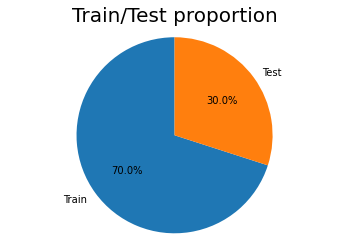

In [8]:
# Divide the dataset in train (which will later be further
# divided into train and validation) and test sets
from sklearn.model_selection import train_test_split

# Divide the dataset into train and test
ratio = 0.7
x_train, x_test, y_train, y_test = [], [], [], []
x_train.append(preprocessed_images[0])
y_train.append(y_total[0])
for i in range(n_classes):
  for j in range(sum(idx_list[:i]) + 1, sum(idx_list[:i]) + int(idx_list[i] * ratio)):
    x_train.append(preprocessed_images[j])
    y_train.append(y_total[j])
  for k in range(sum(idx_list[:i]) + 1 + int(idx_list[i] * ratio), sum(idx_list[:i + 1])):
    x_test.append(preprocessed_images[k])
    y_test.append(y_total[k])

# Convert the resulting lists into Numpy arrays
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print("Number of samples to be used for training:", np.shape(x_train)[0])
print("Number of samples to be used for testing:", np.shape(x_test)[0])

# Plot a pie plot just to show that the partitioning is correct
print("\n")
ax = plt.subplot()
sizes = [np.shape(x_train)[0] + np.shape(y_train)[0],
         np.shape(x_test)[0] + np.shape(y_test)[0]]
ax.pie(sizes, labels = ['Train', 'Test'], autopct = '%1.1f%%',
       shadow = False, startangle = 90)
ax.axis('equal')
plt.title(label = "Train/Test proportion", fontsize = 20)
plt.show()

In [9]:
# The training/validation labels are one-hot encoded
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, n_classes)



---

# Classifier

The classifier I am going to use is a neural network that takes as input the features extracted by the chosen achitecture, which will be "cut" at different points (3 cuts, as required by the assignment). To do so, the approach that I think makes the most sense is to not separate the classification pipeline in two parts, which would be feature extraction first, and then saving these features to later feed them in a separate network. 

Instead, I am going to load the whole architecture, cut the part that I want to use as feature extractor and make it non-trainable - so that the weights that are going to be used will be the ones trained on the Imagenet dataset - and then add an activation layer that will perform the actual classification. This last (classification) layer will be the only trainable part of the network, so the whole net can be seen as a feature extractor (with all the characteristics required by the assignment) which constitutes the input of a single layer neural network ("single layer" if we do not consider the input of course).

I think that this approach, even if slightly different from what has been done during the lab activity, is a valid fine-tuning approach, since all the requirements specified by the assignment are satisfied. The only difference in this approach is that the feature extraction step and the training of the classifier are performed simultaneously instead that in two different steps. Moreover, a neural network with a single layer can for sure be seen as a "classical" classifier.



---


# Network setup

As suggested by the assignment specification, I first tried to use the **VGG16** model, which has been proven to be very effective in the task of object detection and image classification. Unfortunately, the dimension of this model (more than 500MB) made its usage tediously hard to manage in my case, even if the dataset itself is quite small. After wasting hours trying to solve the *OOM (Out Of Memory)* errors I was getting during the training step, I decided to take one step back and to change model. 

I opted for the [**MobileNet**](https://arxiv.org/pdf/1704.04861.pdf) model ("standard" version), which like VGG16 it's available in *Keras* along with the pre-trained weights tuned on the **imagenet** dataset and a preprocessing method to be used on the input instances.
Being more than 30 times lighter than VGG16, MobileNet did not give any problem in terms of memory usage, and I could finally proceed with some fine-tuning experiments.

**NOTE:** since the focus of this assignment is the experimentation of *Transfer Learning* by *Fine Tuning*, I am not going to apply any regularization technique in order to produce stable and reliable models; instead, I am going to just comment the results as they are (meaning I will not try to correct eventual over/underfitting behaviours of the following fine-tuned models).

In [10]:
# Imports of the needed packages/methods/architecture
#from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model

In [11]:
# Load the pre-trained model 
#base_model = VGG16(weights = 'imagenet')
base_model = MobileNet(weights = 'imagenet')
base_model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

As can be seen, the MobileNet architecture is made of a large number of layers (91), which in most part are used to perform single convolutional steps (3 layers for each convolution). Since it is not explicitly required by the assignment, I am not going to further discuss the MobileNet architecture (I think this choice will be appriciated by the person in charge of evaluating this assignment, since explaining this part in depth would require much more text to be read and evaluated).

## Hyperparameters

The hyperparameters I used to train the single layer nnet (the "classical" classifier) are:


*   **Optimizer:** Adam optimizer with learning rate set to 0.0001, which I chose after a couple of experiments, noticing that lowering it led to a really slow (and badly performing) training proces, and augmenting it led to an unconsistent behaviour of both the accuracy and the loss on the trainset and validation set;
*   **Validation/training split:** the ratio between the dimension of the train and validation set is *0.8 train* and *0.2 validation*;

*   **Initializer:** Keras standard Glorot initializer;
*   **Number of epochs:** 50, which was the minimum number of epochs that let the loss and the accuracy converge (at least in the first model). 
*   **Loss function:** categorical crossentropy, since this is a multi-class classification task;
*   **Metrics of evaluation:** accuracy.


## First model

Here in the first fine-tuning experiment, I am going to perform the most basic cut that could be performed, which means I will be using the entire pre-trained network except for the output layer. To do so, I will cut out only the last layer, which is a *fully connected* layer with *1000* neurons (since it was trained on imagenet which contains 1000 classes), in order to add a new output layer with 4 units, one for each of the classes of the new dataset. This layer will take as input the output of the previous one, the "*Reshape*" layer, which as the name suggests reshapes the output of the previous "*Conv2D*" layer in order to feed the resulting *1D feature vector* to the "*Activation*" layer (*(1, 1, 1000) => (1000)*).

In [12]:
# Cut before output layer;
from tensorflow.keras.layers import Dense

tmp = base_model.layers[-2].output
output = Dense(n_classes, activation = 'softmax')(tmp)
model_1 = Model(inputs = base_model.input, outputs = output)

for layer in model_1.layers[: -1]: # All layers are non-trainable except for the last one
  layer.trainable = False

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

As can be seen by the summary above, only **4,004** of the **4,257,868** parameters of the model "*model_1*" are trainable, since I am going to use the pre-trained weights of the original model, and the only layer that needs to be trained is the one I added.

In [13]:
from tensorflow.keras.optimizers import Adam
model_1.compile(optimizer = Adam(learning_rate = 0.0001), 
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
n_epochs = 50

At this point, another preprocessing step needs to be carried out in order to make the input data consistent with the data used to train the MobileNet model. To do so, I am going to use the specific method available in Keras. The following function *preprocess_input()* located in *tensorflow.keras.applications.mobilenet* scales the input pixel values from range [0, 255] to [-1, 1].

In [14]:
from tensorflow.keras.applications.mobilenet import preprocess_input
print("Previous range: [", np.min(x_train[0, :, :, :]), ",", 
      np.max(x_train[0, :, :, :]), "]")
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)
print("Current range: [", np.min(x_train[0, :, :, :]), ",", 
      np.max(x_train[0, :, :, :]), "]")

Previous range: [ 0.0 , 255.0 ]
Current range: [ -1.0 , 1.0 ]


Now that the data is finally ready to be fed into the *model*, and *this* has been defined and compiled, delete the unnecessary data to avoid any problem related to memory usage.

In [15]:
import gc # Import the garbage collector interface
del folders, all_images, y_total, preprocessed_images, ax, tmp
gc.collect() # Here, the number of unreachable objects found by the garbage 
             # collector is given as the output of gc.collect() 

0

The first model can now be trained.

In [16]:
network_history = model_1.fit(x_train, y_train, epochs = n_epochs, verbose = 1,
                              validation_split = 0.2, shuffle = True)

Epoch 1/50
20/20 [==============================] - 13s 180ms/step - loss: 3.0918 - accuracy: 0.2556 - val_loss: 3.0292 - val_accuracy: 0.2357
Epoch 2/50
20/20 [==============================] - 2s 100ms/step - loss: 2.2734 - accuracy: 0.3578 - val_loss: 2.4961 - val_accuracy: 0.2803
Epoch 3/50
20/20 [==============================] - 2s 100ms/step - loss: 1.7421 - accuracy: 0.4601 - val_loss: 1.6324 - val_accuracy: 0.4713
Epoch 4/50
20/20 [==============================] - 2s 99ms/step - loss: 1.3746 - accuracy: 0.5591 - val_loss: 1.4578 - val_accuracy: 0.5287
Epoch 5/50
20/20 [==============================] - 2s 99ms/step - loss: 1.1349 - accuracy: 0.6262 - val_loss: 1.2840 - val_accuracy: 0.5987
Epoch 6/50
20/20 [==============================] - 2s 100ms/step - loss: 0.9602 - accuracy: 0.6853 - val_loss: 1.0799 - val_accuracy: 0.6624
Epoch 7/50
20/20 [==============================] - 2s 115ms/step - loss: 0.8297 - accuracy: 0.7348 - val_loss: 0.8974 - val_accuracy: 0.6943
Epoch 8

In [17]:
# Show results
def show_results(network_history):
  print("Training:")
  accuracy = network_history.history['accuracy'][-1]
  loss = network_history.history['loss'][-1]
  print("Accuracy =", accuracy, "(", round(accuracy, 4) * 100, "% )")
  print("Loss =", loss, "\n")

  print("Validation:")
  val_accuracy = network_history.history['val_accuracy'][-1]
  val_loss = network_history.history['val_loss'][-1]
  print("Validation accuracy =", val_accuracy, "(", round(val_accuracy, 4) * 100, "% )")
  print("Loss =", val_loss)

show_results(network_history)

Training:
Accuracy = 0.9824281334877014 ( 98.24000000000001 % )
Loss = 0.08775696903467178 

Validation:
Validation accuracy = 0.9490445852279663 ( 94.89999999999999 % )
Loss = 0.12157905846834183


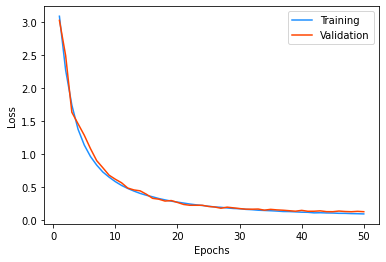

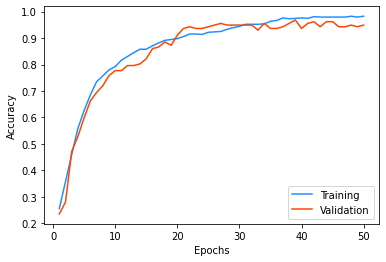

In [18]:
# Plot results
def plot_results(network_history):
  x_plot = list(range(1, n_epochs + 1))
  # Loss
  plt.figure()
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(x_plot, network_history.history['loss'], color = "dodgerblue")
  plt.plot(x_plot, network_history.history['val_loss'], color = "orangered")
  plt.legend(['Training', 'Validation'])
  # Accuracy
  plt.figure()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(x_plot, network_history.history['accuracy'], color = "dodgerblue")
  plt.plot(x_plot, network_history.history['val_accuracy'], color = "orangered")
  plt.legend(['Training', 'Validation'], loc = 4)
  plt.show()

plot_results(network_history)

About the results, it can be seen how the two trends of loss and accuracy for both training and vlaidation sets are quite similar. The gap between the reults obtained on the two sets shows that the model is overfitting. 

Testing of the model on the *testset*:

In [19]:
testing_results_1 = model_1.predict(x_test)
# Convert results to string to compare them with the test labels
testing_results_1 = np.array(np.argmax(testing_results_1, axis = -1), dtype = np.str_)

Testing results:

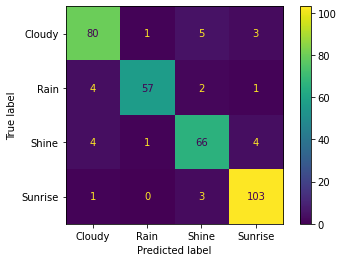


Accuracy achieved on the test set: 0.9080295567310721


In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true = y_test, y_pred = testing_results_1)
test_accuracy = np.mean(np.diagonal(cm/np.sum(cm, axis = 1)))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes).plot()
plt.show()
print("\nAccuracy achieved on the test set:", test_accuracy)

On the test set, the results are quite similar (yet worse) than the ones obtained on the validation set. This again shows that the model is overfitting. 

Please note that executing the training step several times led to different results, with a validation accuracy spanning from 91% to 94%.

In [21]:
# Finished with the first model, delete no-longer-necessary data
del model_1, cm, testing_results_1, network_history
gc.collect()

25252

## Second model

For the second cut, since the MobileNet architecture performs a total of 27 convolutions, I am going to try to ***cut them in half***, and being this number odd, I'm taking 14 as the actual number of convolutions to preserve.

By doing so, I expect the results to be much worse than in the first experiment, since the feature extraction steps will be strongly reduced, meaning that theorically the model will extract features at a much lower depth.

Note that unlike before, this time it is necessary to add a *Flatten* layer in order to give the activation layer the correct input shape. In relation to what I said before about my decision to use a neural network as "classical" classifier, adding one additional layer does not make it "deep", so I think that my assuption still holds.


In [83]:
from tensorflow.keras.layers import Flatten
# Cut at 14th convolution
tmp = base_model.layers[-49].output
tmp = Flatten()(tmp)
output = Dense(n_classes, activation = 'softmax')(tmp)
model_2 = Model(inputs = base_model.input, outputs = output)

for layer in model_2.layers[: -1]: # All layers are non-trainable except for the last one
  layer.trainable = False

model_2.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                   

In contrast to the previous model, now the number of trainable parameters is much higher. There are more than **one hundred** times more trainable parameters this time. This is because along the flow that the data follows during it's "journey" in the neural network, by continuously convolving and max pooling the data, this gets squeezed into a more and more compact representation, thus the number of parameters gets lower along the direction of the data flow.

In [84]:
# There is a "- 3" in the formula below since to count the number of actual
# convolutions the input, output and flatten layers should not be considered;
n_convolutions = int((len(model_2.layers) - 3) / 3) # 3 layers for each convolution
print("Number of convolutions kept from the original model:", n_convolutions)

Number of convolutions kept from the original model: 14


In [102]:
model_2.compile(optimizer = Adam(learning_rate = 0.0001), 
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

In [103]:
network_history = model_2.fit(x_train, y_train, epochs = n_epochs, verbose = 1,
                              validation_split = 0.2, shuffle = True)

Epoch 1/50
20/20 [==============================] - 3s 92ms/step - loss: 0.3380 - accuracy: 0.9345 - val_loss: 4.4140e-06 - val_accuracy: 1.0000
Epoch 2/50
20/20 [==============================] - 1s 70ms/step - loss: 0.0265 - accuracy: 0.9936 - val_loss: 0.0595 - val_accuracy: 0.9809
Epoch 3/50
20/20 [==============================] - 1s 69ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0147 - val_accuracy: 0.9936
Epoch 4/50
20/20 [==============================] - 1s 70ms/step - loss: 6.5976e-04 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 0.9936
Epoch 5/50
20/20 [==============================] - 1s 70ms/step - loss: 3.3443e-04 - accuracy: 1.0000 - val_loss: 0.0109 - val_accuracy: 0.9936
Epoch 6/50
20/20 [==============================] - 1s 73ms/step - loss: 2.8805e-04 - accuracy: 1.0000 - val_loss: 0.0138 - val_accuracy: 0.9936
Epoch 7/50
20/20 [==============================] - 1s 70ms/step - loss: 2.6796e-04 - accuracy: 1.0000 - val_loss: 0.0135 - val_accuracy: 

In [104]:
# Show results
show_results(network_history)

Training:
Accuracy = 1.0 ( 100.0 % )
Loss = 8.306415111292154e-05 

Validation:
Validation accuracy = 0.993630588054657 ( 99.36 % )
Loss = 0.011337006464600563


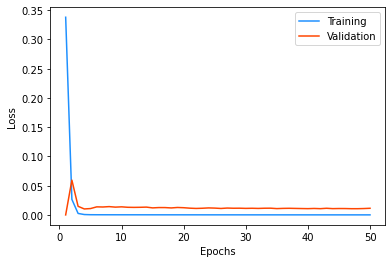

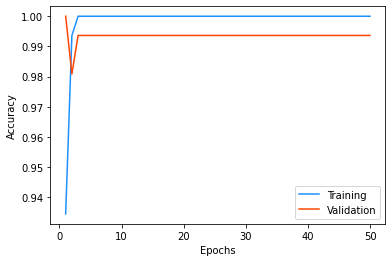

In [105]:
# Plot results
plot_results(network_history)

As shown by the two plots above, the trends of loss and accuracy are also in this case very consistent for both validation and training. In this case, executing the training several times always gave almost exactly the same results; in particolar, the metrics for both train and validation converge really fast to optimal values.

In [45]:
testing_results_2 = model_2.predict(x_test)
# Convert results to string to compare them with the test labels
testing_results_2 = np.array(np.argmax(testing_results_2, axis = -1), dtype = np.str_)

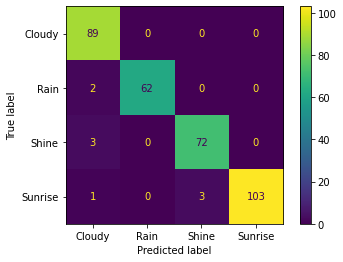


Accuracy achieved on the test set: 0.9728417056074766


In [46]:
cm = confusion_matrix(y_true = y_test, y_pred = testing_results_2)
test_accuracy = np.mean(np.diagonal(cm/np.sum(cm, axis = 1)))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes).plot()
plt.show()
print("\nAccuracy achieved on the test set:", test_accuracy)

Considering the results obtained during the training/validation/testing, what has been achieved is in complete contrast with my initial hypothesis. In fact, now the model does perform **much better** on each one of the sets considered. 

The reason behind this probably lies in the fact that the weights used to pre-train the model were obtained by training it on a very different dataset, and cutting the network in half - as previously stated - increased the number of trainable parameters by a factor of one hundred, allowing the model to have much more "freedom" in the task of learning about this new dataset (even if the trainable layer is only one fully connected layer with four units).

In [65]:
# Finished with the second model, delete no-longer-necessary data
del model_2, cm, testing_results_2, network_history
gc.collect()

12546

## Third model


In this third and last model, I am going to apply the same logic as for the second model. This time I am going to cut the MobileNet architecture "half way" respect to the first and second model. My hypothesis is that this will lead to results which are a mean of the ones obtained so far.

I am going to take **3/4** of the **convolutions** of the original model, which approximately is **20**.

In [75]:
# Cut at 14th convolution
tmp = base_model.layers[-31].output
tmp = Flatten()(tmp)
output = Dense(n_classes, activation = 'softmax')(tmp)
model_3 = Model(inputs = base_model.input, outputs = output)

for layer in model_3.layers[: -1]: # All layers are non-trainable except for the last one
  layer.trainable = False

model_3.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                   

The number of **parameters** is **the same as the second model**; this is because the shape of the output of the previous layer is the same as the one where I cut the model number two (14, 14, 512).

In [76]:
n_convolutions = int((len(model_3.layers) - 3) / 3)
print("Number of convolutions kept from the original model:", n_convolutions)

Number of convolutions kept from the original model: 20


In [77]:
model_3.compile(optimizer = Adam(learning_rate = 0.0001), 
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

In [78]:
network_history = model_3.fit(x_train, y_train, epochs = n_epochs, verbose = 1,
                              validation_split = 0.2, shuffle = True)

Epoch 1/50
20/20 [==============================] - 4s 114ms/step - loss: 1.7939 - accuracy: 0.5208 - val_loss: 0.9271 - val_accuracy: 0.6433
Epoch 2/50
20/20 [==============================] - 2s 83ms/step - loss: 0.2622 - accuracy: 0.9026 - val_loss: 0.3826 - val_accuracy: 0.8599
Epoch 3/50
20/20 [==============================] - 2s 83ms/step - loss: 0.1336 - accuracy: 0.9617 - val_loss: 0.2715 - val_accuracy: 0.8981
Epoch 4/50
20/20 [==============================] - 2s 82ms/step - loss: 0.0591 - accuracy: 0.9920 - val_loss: 0.2139 - val_accuracy: 0.9299
Epoch 5/50
20/20 [==============================] - 2s 83ms/step - loss: 0.0345 - accuracy: 0.9968 - val_loss: 0.1938 - val_accuracy: 0.9236
Epoch 6/50
20/20 [==============================] - 2s 84ms/step - loss: 0.0188 - accuracy: 1.0000 - val_loss: 0.2726 - val_accuracy: 0.8917
Epoch 7/50
20/20 [==============================] - 2s 84ms/step - loss: 0.0150 - accuracy: 1.0000 - val_loss: 0.2180 - val_accuracy: 0.9172
Epoch 8/50
2

In [79]:
# Show results
show_results(network_history)

Training:
Accuracy = 1.0 ( 100.0 % )
Loss = 0.00103971385397017 

Validation:
Validation accuracy = 0.9490445852279663 ( 94.89999999999999 % )
Loss = 0.12906979024410248


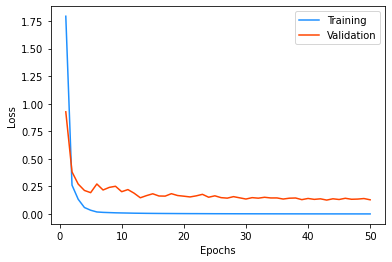

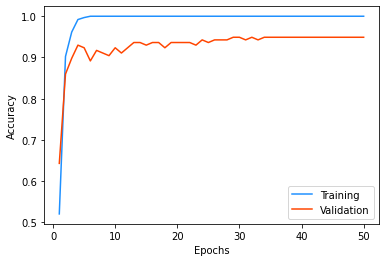

In [80]:
# Plot results
plot_results(network_history)

Again, the trends look nicely correlated, but it can be easily seen how the model is now overfitting more than the previous models.

**NOTE:** I executed the training a few times, and some of these resulted in "unlucky" results, where the values immediately converged to fixed values. Anyway, most of the times it gave almost the same exact results that you see in the plots above (assuming who is reading this did not already re-executed the code and got an "unlucky" result).

In [81]:
testing_results_3 = model_3.predict(x_test)
# Convert results to string to compare them with the test labels
testing_results_3 = np.array(np.argmax(testing_results_3, axis = -1), dtype = np.str_)

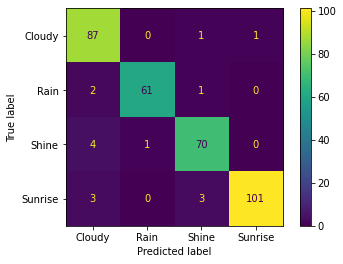


Accuracy achieved on the test set: 0.9519779142164584


In [82]:
cm = confusion_matrix(y_true = y_test, y_pred = testing_results_3)
test_accuracy = np.mean(np.diagonal(cm/np.sum(cm, axis = 1)))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes).plot()
plt.show()
print("\nAccuracy achieved on the test set:", test_accuracy)

This time my predictions were correct. The final results obtained on the test set lie in between the results of the two previous models as I predicted.



---

# Additional considerations about the results

As can be seen in the confusion matrices after the testing of each model, most of the **incorrect classifications** consist of images mistakenly classified as "**cloudy**". This actually makes sense, since if we look at the dataset we can see that many of the instances of the three classes "*Shine*", "*Sunrise*" and "*Rainy*" all contain many images where there is a strong presence of clouds. As one can imagine, the presence of what is the main subject of one class into other classes of the dataset can easily confuse the model. An example is shown below. 

In the class "*Rainy*" there are not many images with lots of clouds, actually almost none, but being gray the predominant color in these images, and being gray the color of the clouds when the sky is cloudy, this could be the actual correlation between the two classes, and the reason behind most of the wrong classifications. For this specific problem, one way to solve it could be to use a model built to take as input mono-channel images, so that the color information can no longer influence the results.

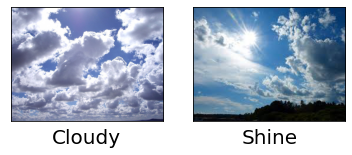

In [100]:
ax = plt.subplot(1, 2, 1)
path = '/content/drive/MyDrive/data/Multi-class Weather Dataset/Cloudy/cloudy108.jpg'
plt.imshow(image.load_img(path))
plt.title(label = classes[0], fontsize = 20, y = -0.25)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(1, 2, 2)
path = '/content/drive/MyDrive/data/Multi-class Weather Dataset/Shine/shine145.jpg'
plt.imshow(image.load_img(path))
plt.title(label = classes[2], fontsize = 20, y = -0.25)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)